In [1]:
print("Machine Learning Otimização com exploração aleatória".lower().replace(" ","-"))

machine-learning-otimização-com-exploração-aleatória


In [1]:
import pandas as pd

path = "project-1-data.csv"
dados = pd.read_csv(path).drop(columns=["Unnamed: 0"], axis=1)
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano
0,30941.02,1,18,35085.22134
1,40557.96,1,20,12622.05362
2,89627.50,0,12,11440.79806
3,95276.14,0,3,43167.32682
4,117384.68,1,4,12770.11290


In [2]:
# situação horrível de "azar" onde as classes estão ordenadas por padrão

dados_azar = dados.sort_values("vendido", ascending=True)
x_azar = dados_azar[["preco", "idade_do_modelo","km_por_ano"]]
y_azar = dados_azar["vendido"]
dados_azar.head()

,preco,vendido,idade_do_modelo,km_por_ano
4999,74023.29,0,12,24812.80412
5322,84843.49,0,13,23095.63834
5319,83100.27,0,19,36240.72746
5316,87932.13,0,16,32249.56426
5315,77937.01,0,15,28414.50704


In [3]:
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier
import numpy as np

SEED = 301
np.random.seed(SEED)

modelo = DummyClassifier()
results = cross_validate(modelo, x_azar, y_azar, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com dummy stratified, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Accuracy com dummy stratified, 10 = [58.00, 58.00]


In [4]:
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier

SEED = 301
np.random.seed(SEED)

modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com cross validation, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Accuracy com cross validation, 10 = [73.83, 77.73]


In [5]:
# gerando dados alatorios de modelos de carro para simulacao de agrupamento ao usar nosso estimador

np.random.seed(SEED)
dados['modelo'] = dados.idade_do_modelo + np.random.randint(-2, 3, size=10000)
dados.modelo = dados.modelo + abs(dados.modelo.min()) + 1
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano,modelo
0,30941.02,1,18,35085.22134,18
1,40557.96,1,20,12622.05362,24
2,89627.50,0,12,11440.79806,14
3,95276.14,0,3,43167.32682,6
4,117384.68,1,4,12770.11290,5


In [6]:
def imprime_resultados(results):
  media = results['test_score'].mean() * 100
  desvio = results['test_score'].std() * 100
  print("Accuracy médio %.2f" % media)
  print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))

In [7]:
# GroupKFold em um pipeline com StandardScaler e SVC

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

scaler = StandardScaler()
modelo = SVC()

pipeline = Pipeline([('transformacao',scaler), ('estimador',modelo)])

cv = GroupKFold(n_splits = 10)
results = cross_validate(pipeline, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 76.68
Intervalo [74.28, 79.08]


In [8]:
# GroupKFold para analisar como o modelo se comporta com novos grupos

from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 75.78
Intervalo [73.67, 77.90]


In [9]:
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV

SEED = 301
np.random.seed(SEED)

espaco_de_paramentros = {
    "max_depth": [3,5],
    "min_samples_split": [32, 64, 128],
    "min_samples_leaf": [32, 64, 128],
    "criterion": ["gini", "entropy"]
}

busca = RandomizedSearchCV(
    DecisionTreeClassifier(),
    espaco_de_paramentros,
    n_iter= 16,
    cv= KFold(n_splits=5, shuffle=True),
    random_state= SEED)
busca.fit(x_azar, y_azar)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.027982,0.002606,0.002998,0.001094,128,128,5,gini,"{'min_samples_split': 128, 'min_samples_leaf':...",0.784,0.769,0.7985,0.793,0.7730,0.7835,0.011278,13
1,0.018988,0.000631,0.002799,0.000400,64,32,3,gini,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.784,0.776,0.8025,0.793,0.7795,0.7870,0.009618,1
2,0.018189,0.000399,0.002798,0.000399,64,128,3,gini,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.784,0.776,0.8025,0.793,0.7795,0.7870,0.009618,1
3,0.033379,0.000488,0.002599,0.000489,32,64,5,entropy,"{'min_samples_split': 32, 'min_samples_leaf': ...",0.784,0.769,0.8005,0.793,0.7730,0.7839,0.011825,7
4,0.033178,0.000400,0.002799,0.000400,64,64,5,entropy,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.784,0.769,0.8005,0.793,0.7730,0.7839,0.011825,7


In [10]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(busca, x_azar, y_azar, cv=KFold(n_splits=5, shuffle=True))
scores

array([0.7825, 0.783 , 0.794 , 0.781 , 0.795 ])

In [11]:
def imprime_scores(scores):
  media = scores.mean() * 100
  desvio = scores.std() * 100
  print("Accuracy médio %.2f" % media)
  print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))

imprime_scores(scores)

Accuracy médio 78.71
Intervalo [77.49, 79.93]


In [12]:
melhor = busca.best_estimator_
melhor

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=64)

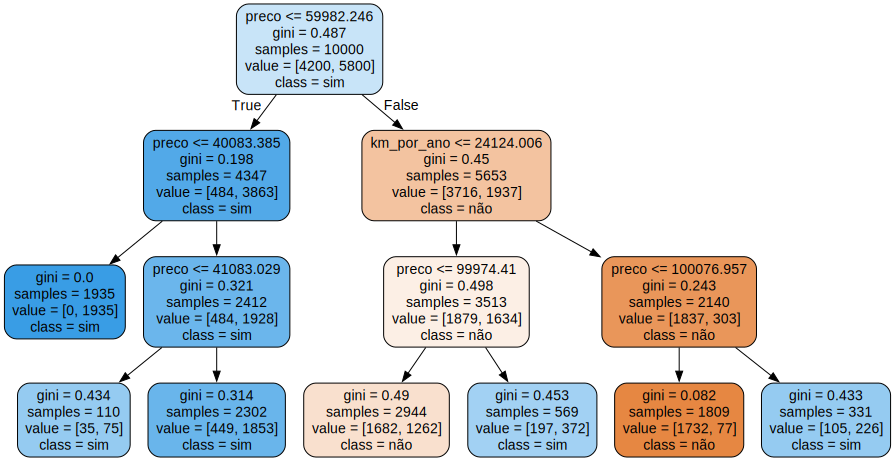

In [13]:
from sklearn.tree import export_graphviz
import graphviz

features = x_azar.columns
dot_data = export_graphviz(melhor, out_file=None, filled=True, rounded=True,
                           class_names=["não", "sim"], feature_names=features)
graph = graphviz.Source(dot_data)
graph

In [14]:
# Customizando o espaço de hiper parametros:

from scipy.stats import randint
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV

SEED = 301
np.random.seed(SEED)

espaco_de_paramentros = {
    "max_depth": [3,5, 10, 15, 20, 30, None],
    "min_samples_split": randint(32, 128),
    "min_samples_leaf": randint(32, 128),
    "criterion": ["gini", "entropy"]
}

busca = RandomizedSearchCV(
    DecisionTreeClassifier(),
    espaco_de_paramentros,
    n_iter= 16,
    cv= KFold(n_splits=5, shuffle=True),
    random_state= SEED)
busca.fit(x_azar, y_azar)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.024784,0.001832,0.003398,0.000799,entropy,3,71,100,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.7840,0.7760,0.8025,0.7930,0.7795,0.7870,0.009618,1
1,0.036577,0.001018,0.002798,0.000399,gini,15,93,111,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",0.7740,0.7725,0.7830,0.7805,0.7725,0.7765,0.004393,14
2,0.034378,0.001742,0.002599,0.000490,gini,20,124,88,"{'criterion': 'gini', 'max_depth': 20, 'min_sa...",0.7705,0.7745,0.7990,0.7790,0.7735,0.7793,0.010221,8
3,0.045371,0.002059,0.002799,0.000401,gini,None,46,62,"{'criterion': 'gini', 'max_depth': None, 'min_...",0.7575,0.7730,0.7725,0.7835,0.7560,0.7685,0.010378,16
4,0.032779,0.001325,0.002999,0.000001,gini,15,126,84,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",0.7705,0.7735,0.7995,0.7790,0.7745,0.7794,0.010413,7


In [15]:
scores = cross_val_score(busca, x_azar, y_azar, cv=KFold(n_splits=5, shuffle=True))
imprime_scores(scores)
melhor = busca.best_estimator_
print(melhor)

Accuracy médio 78.71
Intervalo [77.49, 79.93]
DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=71,
                       min_samples_split=100)


In [16]:
resultados_ordenados_pela_media = resultados.sort_values("mean_test_score", ascending=False)
for indice, linha in resultados_ordenados_pela_media.iterrows():
    print(f"{linha.mean_test_score*100:.2f}% +-{linha.std_test_score*2*100:.3f} | {linha.params}")

78.70% +-1.924 | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 71, 'min_samples_split': 100}
78.39% +-2.365 | {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 73, 'min_samples_split': 72}
78.39% +-2.365 | {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 67}
78.10% +-1.675 | {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 108, 'min_samples_split': 110}
78.04% +-1.942 | {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 125, 'min_samples_split': 59}
77.99% +-1.235 | {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 103, 'min_samples_split': 96}
77.94% +-2.083 | {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 126, 'min_samples_split': 84}
77.93% +-2.044 | {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 124, 'min_samples_split': 88}
77.92% +-0.926 | {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 101, 'min_samples_split': 52}
77.91% +-1.353 | {'criterion': 'entropy', 

In [17]:
# Explorando mais a fundo, agora com 64 iteracoes:

from scipy.stats import randint
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV

SEED = 301
np.random.seed(SEED)

espaco_de_paramentros = {
    "max_depth": [3,5, 10, 15, 20, 30, None],
    "min_samples_split": randint(32, 128),
    "min_samples_leaf": randint(32, 128),
    "criterion": ["gini", "entropy"]
}

busca = RandomizedSearchCV(
    DecisionTreeClassifier(),
    espaco_de_paramentros,
    n_iter= 64,
    cv= KFold(n_splits=5, shuffle=True),
    random_state= SEED)
busca.fit(x_azar, y_azar)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.024584,0.002331,0.002998,0.000632,entropy,3,71,100,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.7840,0.7760,0.8025,0.7930,0.7795,0.7870,0.009618,1
1,0.037178,0.001326,0.002599,0.000490,gini,15,93,111,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",0.7740,0.7725,0.7830,0.7805,0.7725,0.7765,0.004393,46
2,0.034578,0.001854,0.002798,0.000400,gini,20,124,88,"{'criterion': 'gini', 'max_depth': 20, 'min_sa...",0.7705,0.7745,0.7990,0.7790,0.7735,0.7793,0.010221,27
3,0.047571,0.004267,0.002798,0.000400,gini,None,46,62,"{'criterion': 'gini', 'max_depth': None, 'min_...",0.7575,0.7730,0.7725,0.7835,0.7560,0.7685,0.010378,64
4,0.033178,0.001599,0.002599,0.000490,gini,15,126,84,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",0.7705,0.7735,0.7995,0.7790,0.7745,0.7794,0.010413,26


In [18]:
resultados_ordenados_pela_media = resultados.sort_values("mean_test_score", ascending=False)
for indice, linha in resultados_ordenados_pela_media.iterrows():
    print(f"{linha.mean_test_score*100:.2f}% +-{linha.std_test_score*100*2:.2f} | {linha.params}")

78.70% +-1.92 | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 71, 'min_samples_split': 100}
78.70% +-1.92 | {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 69, 'min_samples_split': 124}
78.70% +-1.92 | {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 63, 'min_samples_split': 88}
78.70% +-1.92 | {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 67, 'min_samples_split': 76}
78.70% +-1.92 | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 65, 'min_samples_split': 50}
78.70% +-1.92 | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 120, 'min_samples_split': 46}
78.70% +-1.92 | {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 53, 'min_samples_split': 111}
78.70% +-1.92 | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 106, 'min_samples_split': 108}
78.39% +-2.37 | {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 67}
78.39% +-2.37 | {'criterion': 'gini', 'max_depth': 5, '

Comparando GridSearchCV com RandomizedSearch:

In [19]:
import time
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

SEED = 301
np.random.seed(SEED)

espaco_de_paramentros = {
    "n_estimators": [10, 100],
    "max_depth": [3,5],
    "min_samples_split": [32, 64, 128],
    "min_samples_leaf": [32, 64, 128],
    "bootstrap": [True, False],
    "criterion": ["gini", "entropy"]
}


tic = time.time()
busca = GridSearchCV(
    RandomForestClassifier(),
    espaco_de_paramentros,
    cv= KFold(n_splits=5, shuffle=True))
busca.fit(x_azar, y_azar)
tac = time.time()

tempo_que_passou = tac-tic
print(f"Tempo: {tempo_que_passou:.2f} segundos")

resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

Tempo: 370.81 segundos


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.069356,0.003719,0.004999,1.386932e-06,True,gini,3,32,32,10,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7745,0.7560,0.7490,0.7850,0.7450,0.7619,0.015357,130
1,0.672586,0.018045,0.025184,3.999999e-04,True,gini,3,32,32,100,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7655,0.7555,0.7945,0.7850,0.7625,0.7726,0.014685,93
2,0.071955,0.004855,0.004997,6.503192e-07,True,gini,3,32,64,10,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7780,0.7635,0.7835,0.7845,0.7560,0.7731,0.011373,89
3,0.653796,0.012311,0.024985,6.326374e-04,True,gini,3,32,64,100,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7425,0.7550,0.7950,0.7850,0.7620,0.7679,0.019356,119
4,0.067359,0.004221,0.004997,5.091228e-07,True,gini,3,32,128,10,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7755,0.7405,0.7485,0.7760,0.7630,0.7607,0.014250,135


In [20]:
resultados_ordenados_pela_media = resultados.sort_values("mean_test_score", ascending=False)
for indice, linha in resultados_ordenados_pela_media[:5].iterrows():
    print(f"{linha.mean_test_score*100:.2f}% +-{linha.std_test_score*100*2:.2f}% | {linha.params}")

78.01% +-2.03% | {'bootstrap': False, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 32, 'min_samples_split': 64, 'n_estimators': 10}
77.84% +-2.02% | {'bootstrap': True, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 32, 'min_samples_split': 128, 'n_estimators': 10}
77.82% +-3.00% | {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 64, 'n_estimators': 10}
77.79% +-2.71% | {'bootstrap': False, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 64, 'n_estimators': 10}
77.76% +-3.32% | {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 64, 'n_estimators': 100}


In [21]:
# tic = time.time()
# scores = cross_val_score(busca, x_azar, y_azar, cv=KFold(n_splits=5, shuffle=True))
# tac = time.time()
# tempo_que_passou = tac-tic
# print(f"Tempo: {tempo_que_passou:.2f} segundos")

# imprime_scores(scores)
# melhor = busca.best_estimator_
# print(melhor)

# É absurdo o tempo que levaria para rodar isso

In [22]:
SEED = 301
np.random.seed(SEED)

espaco_de_paramentros = {
    "n_estimators": [10, 100],
    "max_depth": [3,5],
    "min_samples_split": [32, 64, 128],
    "min_samples_leaf": [32, 64, 128],
    "bootstrap": [True, False],
    "criterion": ["gini", "entropy"]
}


tic = time.time()
busca = RandomizedSearchCV(
    RandomForestClassifier(),
    espaco_de_paramentros,
    n_iter= 20,
    cv= KFold(n_splits=5, shuffle=True))
busca.fit(x_azar, y_azar)
tac = time.time()

tempo_que_passou = tac-tic
print(f"Tempo: {tempo_que_passou:.2f} segundos")

resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

Tempo: 53.47 segundos


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_criterion,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.721956,0.021772,0.024784,3.994985e-04,100,32,128,3,entropy,True,"{'n_estimators': 100, 'min_samples_split': 32,...",0.771,0.7740,0.7925,0.7775,0.7560,0.7742,0.011724,10
1,0.102536,0.005568,0.005197,3.997088e-04,10,32,128,5,entropy,True,"{'n_estimators': 10, 'min_samples_split': 32, ...",0.750,0.7785,0.7820,0.7785,0.7645,0.7707,0.011969,13
2,1.076336,0.008643,0.028183,3.992081e-04,100,32,32,5,entropy,True,"{'n_estimators': 100, 'min_samples_split': 32,...",0.771,0.7745,0.7930,0.7785,0.7585,0.7751,0.011178,6
3,0.068757,0.003368,0.004797,7.480861e-04,10,128,32,3,gini,True,"{'n_estimators': 10, 'min_samples_split': 128,...",0.750,0.7600,0.7450,0.7390,0.7520,0.7492,0.007026,20
4,0.095540,0.006557,0.004997,5.091228e-07,10,64,32,3,entropy,False,"{'n_estimators': 10, 'min_samples_split': 64, ...",0.771,0.7740,0.7635,0.7370,0.7585,0.7608,0.013094,18


In [23]:
resultados_ordenados_pela_media = resultados.sort_values("mean_test_score", ascending=False)
for indice, linha in resultados_ordenados_pela_media[:5].iterrows():
    print(f"{linha.mean_test_score*100:.2f}% +-{linha.std_test_score*100*2:.2f}% | {linha.params}")

77.61% +-2.51% | {'n_estimators': 100, 'min_samples_split': 32, 'min_samples_leaf': 32, 'max_depth': 5, 'criterion': 'gini', 'bootstrap': False}
77.56% +-2.27% | {'n_estimators': 100, 'min_samples_split': 32, 'min_samples_leaf': 128, 'max_depth': 3, 'criterion': 'gini', 'bootstrap': False}
77.56% +-2.38% | {'n_estimators': 100, 'min_samples_split': 64, 'min_samples_leaf': 32, 'max_depth': 5, 'criterion': 'entropy', 'bootstrap': True}
77.55% +-3.20% | {'n_estimators': 10, 'min_samples_split': 32, 'min_samples_leaf': 64, 'max_depth': 3, 'criterion': 'entropy', 'bootstrap': False}
77.54% +-3.46% | {'n_estimators': 10, 'min_samples_split': 32, 'min_samples_leaf': 32, 'max_depth': 5, 'criterion': 'gini', 'bootstrap': True}


In [24]:
tic = time.time()
scores = cross_val_score(busca, x_azar, y_azar, cv=KFold(n_splits=5, shuffle=True))
tac = time.time()
tempo_que_passou = tac-tic
print(f"Tempo: {tempo_que_passou:.2f} segundos")

imprime_scores(scores)
melhor = busca.best_estimator_
print(melhor)

Tempo: 228.12 segundos
Accuracy médio 77.59
Intervalo [76.47, 78.71]
RandomForestClassifier(bootstrap=False, max_depth=5, min_samples_leaf=32,
                       min_samples_split=32)


In [25]:
SEED = 301
np.random.seed(SEED)

espaco_de_paramentros = {
    "n_estimators": randint(10,101),
    "max_depth": randint(3,6),
    "min_samples_split": randint(32,129),
    "min_samples_leaf": randint(32,129),
    "bootstrap": [True, False],
    "criterion": ["gini", "entropy"]
}

tic = time.time()
busca = RandomizedSearchCV(
    RandomForestClassifier(),
    espaco_de_paramentros,
    n_iter= 80,
    cv= KFold(n_splits=5, shuffle=True))
busca.fit(x_azar, y_azar)
tac = time.time()

tempo_que_passou = tac-tic
print(f"Tempo: {tempo_que_passou:.2f} segundos")

resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

Tempo: 187.61 segundos


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.638406,0.007022,0.022386,0.000490,False,gini,3,50,93,89,"{'bootstrap': False, 'criterion': 'gini', 'max...",0.7715,0.7620,0.7750,0.7855,0.7580,0.7704,0.009744,75
1,0.515280,0.009663,0.020188,0.000400,True,gini,3,88,104,80,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7715,0.7575,0.7925,0.7855,0.7575,0.7729,0.014277,63
2,0.484501,0.008419,0.019588,0.000489,True,gini,3,126,84,77,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7685,0.7695,0.7925,0.7795,0.7575,0.7735,0.011781,59
3,0.324799,0.006257,0.013392,0.000490,True,gini,3,57,73,50,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7720,0.7670,0.7830,0.7865,0.7580,0.7733,0.010429,60
4,0.535471,0.008053,0.018987,0.000630,True,gini,4,52,88,68,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7720,0.7685,0.7930,0.7850,0.7585,0.7754,0.012220,30


In [26]:
resultados_ordenados_pela_media = resultados.sort_values("mean_test_score", ascending=False)
for indice, linha in resultados_ordenados_pela_media[:5].iterrows():
    print(f"{linha.mean_test_score*100:.2f}% +-{linha.std_test_score*100*2:.2f}% | {linha.params}")

77.90% +-2.46% | {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 84, 'min_samples_split': 89, 'n_estimators': 48}
77.85% +-3.11% | {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 32, 'min_samples_split': 96, 'n_estimators': 18}
77.79% +-3.15% | {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 121, 'min_samples_split': 47, 'n_estimators': 27}
77.75% +-2.38% | {'bootstrap': False, 'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 96, 'min_samples_split': 98, 'n_estimators': 11}
77.71% +-2.87% | {'bootstrap': True, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 63, 'min_samples_split': 88, 'n_estimators': 69}


In [28]:
# 0.6 treino
# 0.2 teste
# 0.2 validacao

SEED = 301
np.random.seed(SEED)

from sklearn.model_selection import train_test_split
x_treino_teste, x_validacao, y_treino_teste, y_validacao = train_test_split(x_azar, y_azar, test_size=0.2, shuffle=True, stratify=y_azar)

print(x_treino_teste.shape)
print(x_validacao.shape)
print(y_treino_teste.shape)
print(y_validacao.shape)

(8000, 3)
(2000, 3)
(8000,)
(2000,)


In [30]:
from sklearn.model_selection import StratifiedShuffleSplit
SEED = 301
np.random.seed(SEED)

espaco_de_paramentros = {
    "n_estimators": randint(10,101),
    "max_depth": randint(3,6),
    "min_samples_split": randint(32,129),
    "min_samples_leaf": randint(32,129),
    "bootstrap": [True, False],
    "criterion": ["gini", "entropy"]
}

split = StratifiedShuffleSplit(n_splits=1, test_size=0.25)

tic = time.time()
busca = RandomizedSearchCV(
    RandomForestClassifier(),
    espaco_de_paramentros,
    n_iter= 5,
    cv= split)
busca.fit(x_treino_teste, y_treino_teste)
tac = time.time()

tempo_que_passou = tac-tic
print(f"Tempo: {tempo_que_passou:.2f} segundos")

resultados = pd.DataFrame(busca.cv_results_)
resultados.head()


Tempo: 2.69 segundos


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
0,0.551987,0.0,0.023014,0.0,False,gini,3,50,93,89,"{'bootstrap': False, 'criterion': 'gini', 'max...",0.7745,0.7745,0.0,2
1,0.490343,0.0,0.031979,0.0,True,gini,3,88,104,80,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7735,0.7735,0.0,5
2,0.431218,0.0,0.021781,0.0,True,gini,3,126,84,77,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7745,0.7745,0.0,2
3,0.301411,0.0,0.013992,0.0,True,gini,3,57,73,50,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7750,0.7750,0.0,1
4,0.439233,0.0,0.019042,0.0,True,gini,4,52,88,68,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7745,0.7745,0.0,2


In [31]:
tic = time.time()
scores = cross_val_score(busca, x_validacao, y_validacao, cv=split)
tac = time.time()
tempo_que_passou = tac-tic
print(f"Tempo: {tempo_que_passou:.2f} segundos")
scores

Tempo: 0.83 segundos


array([0.754])

In [32]:
from sklearn.model_selection import StratifiedShuffleSplit
SEED = 301
np.random.seed(SEED)

espaco_de_paramentros = {
    "n_estimators": randint(10,101),
    "max_depth": randint(3,6),
    "min_samples_split": randint(32,129),
    "min_samples_leaf": randint(32,129),
    "bootstrap": [True, False],
    "criterion": ["gini", "entropy"]
}

split = StratifiedShuffleSplit(n_splits=5, test_size=0.25)

tic = time.time()
busca = RandomizedSearchCV(
    RandomForestClassifier(),
    espaco_de_paramentros,
    n_iter= 5,
    cv= split)
busca.fit(x_treino_teste, y_treino_teste)
tac = time.time()

tempo_que_passou = tac-tic
print(f"Tempo: {tempo_que_passou:.2f} segundos")

resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

Tempo: 11.64 segundos


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.536268,0.021973,0.024185,1.469127e-03,False,gini,3,50,93,89,"{'bootstrap': False, 'criterion': 'gini', 'max...",0.7740,0.7795,0.7810,0.7735,0.7885,0.7793,0.005464,1
1,0.434132,0.008908,0.020987,3.873843e-07,True,gini,3,88,104,80,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7735,0.7800,0.7810,0.7735,0.7885,0.7793,0.005573,1
2,0.403950,0.007436,0.020988,4.264961e-07,True,gini,3,126,84,77,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7730,0.7800,0.7805,0.7625,0.7885,0.7769,0.008714,3
3,0.276829,0.004688,0.014592,4.894742e-04,True,gini,3,57,73,50,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7730,0.7735,0.7810,0.7655,0.7880,0.7762,0.007672,4
4,0.436930,0.009573,0.019588,4.889093e-04,True,gini,4,52,88,68,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7745,0.7785,0.7815,0.7485,0.7895,0.7745,0.013900,5


In [34]:
tic = time.time()
scores = cross_val_score(busca, x_azar, y_azar, cv=KFold(n_splits=5, shuffle=True))
tac = time.time()
tempo_que_passou = tac-tic
print(f"Tempo: {tempo_que_passou:.2f} segundos")

imprime_scores(scores)
melhor = busca.best_estimator_
print(melhor)

Tempo: 67.05 segundos
Accuracy médio 77.34
Intervalo [76.54, 78.14]
RandomForestClassifier(bootstrap=False, max_depth=3, min_samples_leaf=50,
                       min_samples_split=93, n_estimators=89)
